In [41]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

In [42]:
img_size = 224

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

In [43]:
!git clone https://github.com/anesmeftah/deep-learning-roadmap.git

fatal: destination path 'deep-learning-roadmap' already exists and is not an empty directory.


In [44]:
trainset = torchvision.datasets.ImageFolder(root='/content/deep-learning-roadmap/Paper Implementation/ViT/test/' , transform=transform)
testset = torchvision.datasets.ImageFolder(root='/content/deep-learning-roadmap/Paper Implementation/ViT/test/' , transform=transform)


In [45]:
trainset.classes

['pizza', 'steak', 'sushi']

In [46]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset , 32 , shuffle= True)
testloader = DataLoader(testset , 32 , shuffle= True)
trainloader , testloader

(<torch.utils.data.dataloader.DataLoader at 0x795f420cff50>,
 <torch.utils.data.dataloader.DataLoader at 0x795f4205c3e0>)

In [47]:
image_batch, label_batch = next(iter(trainloader))

image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

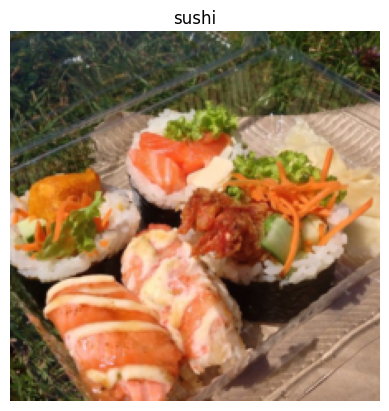

In [48]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(trainset.classes[label])
plt.axis(False)

In [49]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [50]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


In [51]:
# View single image function
def view_image(trainset , image , label):
  plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
  plt.title(trainset.classes[label])
  plt.axis(False)

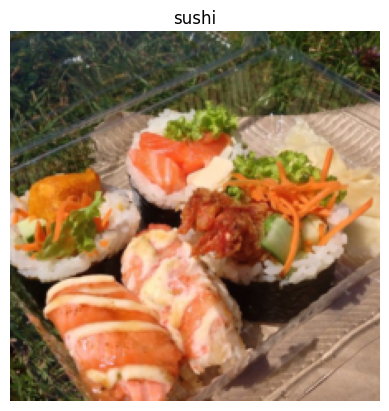

In [52]:
view_image(trainset , image , label)

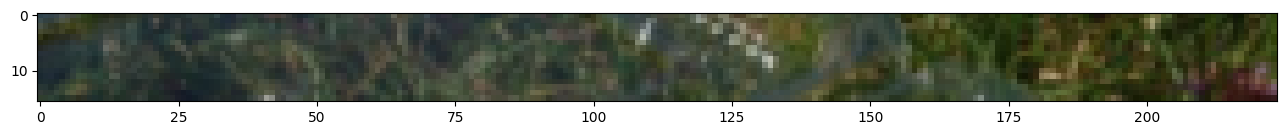

In [53]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


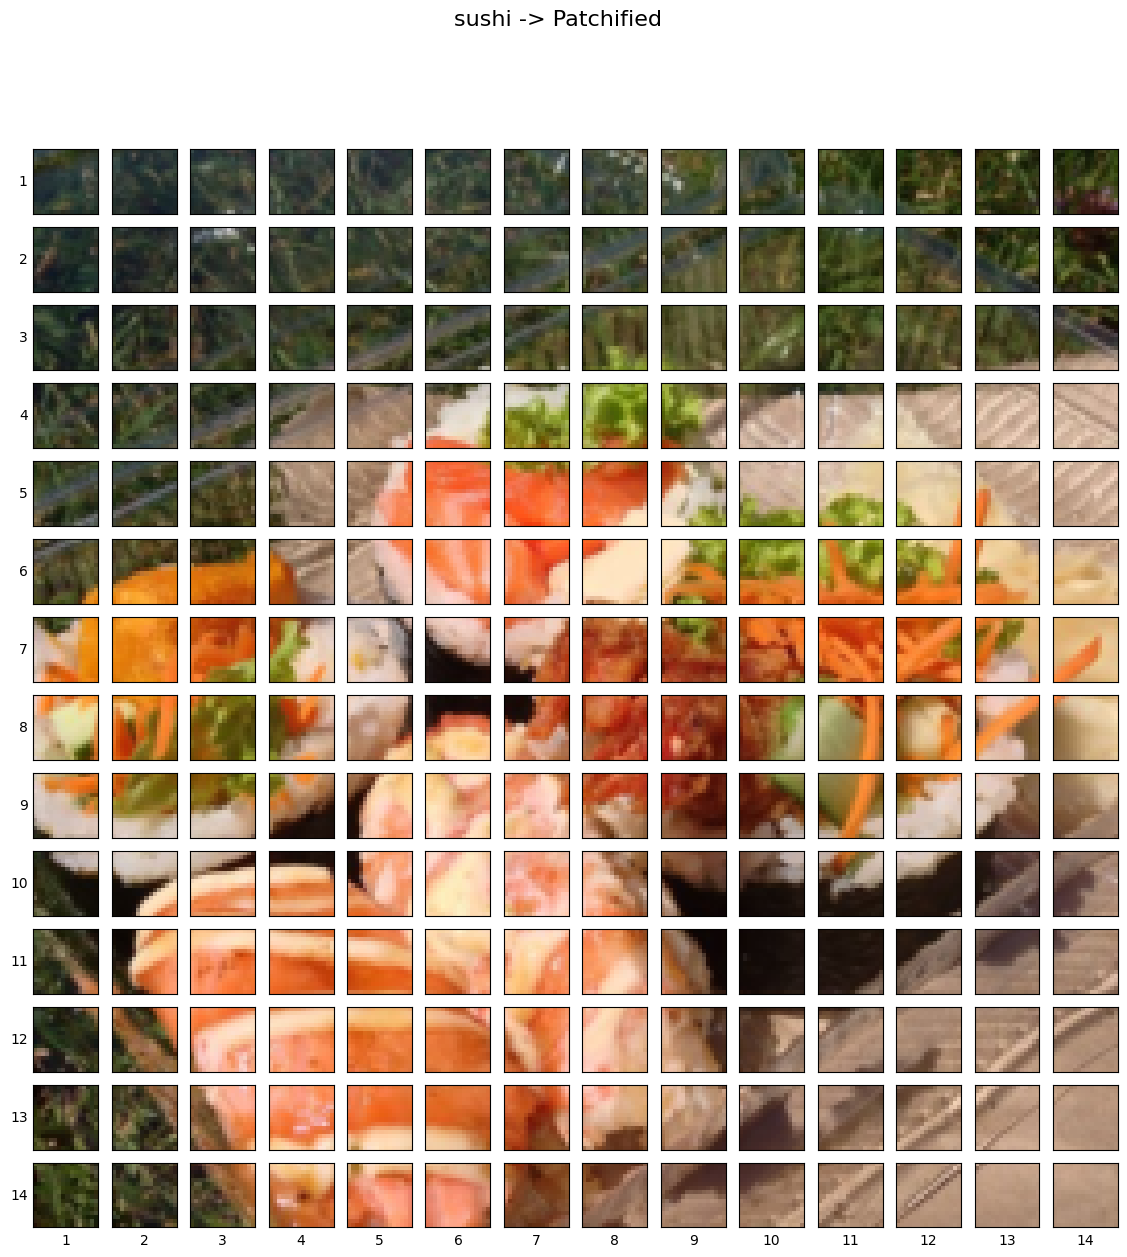

In [54]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{trainset.classes[label]} -> Patchified", fontsize=16)
plt.show()

In [55]:
patch_size = 16
#Create the Conv2d layer

conv2d = nn.Conv2d(in_channels= 3,
                   out_channels= 768,
                   kernel_size= patch_size,
                   stride= patch_size,
                   padding= 0)


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

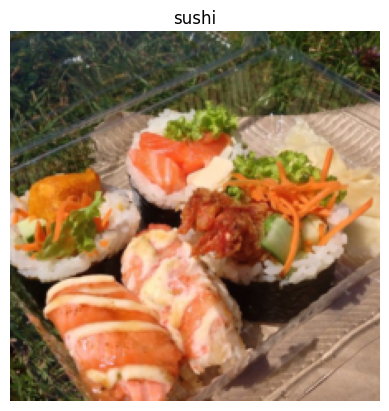

In [56]:
# View single image

plt.imshow(image.permute(1, 2, 0))
plt.title(trainset.classes[label])
plt.axis(False)

In [57]:
print(image.shape)
print(image.unsqueeze(0).shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [58]:
img_out_conv = conv2d(image.unsqueeze(0))
print(img_out_conv.shape)

torch.Size([1, 768, 14, 14])


Let's visualize five random feature maps to see what they look like

Showing random convolutional feature maps from indexes: [154, 646, 105, 131, 364]


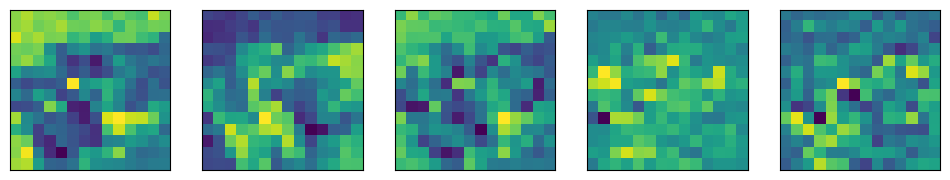

In [59]:
import random
random_indexes = random.sample(range(0,768) , k=5) #pick 5 numbers
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

fig , axs = plt.subplots(nrows = 1 , ncols = 5 , figsize=(12,12))
for i, idx in enumerate(random_indexes):
  img_conv_feature_map = img_out_conv[:, idx, : , :]
  axs[i].imshow(img_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);


let's check out the numerical form

In [60]:
#Get a single feature map in tensor form

single_feature_map = img_out_conv[:, 0, :, :]
single_feature_map , single_feature_map.requires_grad

(tensor([[[-0.0702, -0.0255, -0.0513, -0.0041, -0.0592, -0.0688, -0.0433,
           -0.0385, -0.0374,  0.0110, -0.0224, -0.0564,  0.0352, -0.0373],
          [ 0.0473, -0.0443,  0.0698, -0.0225,  0.0044, -0.0288, -0.0542,
           -0.0312, -0.0430, -0.0370, -0.0509, -0.0449, -0.0625, -0.0972],
          [-0.0174, -0.0203,  0.0113, -0.0124, -0.0600, -0.0220, -0.1085,
           -0.0154, -0.0611, -0.0289, -0.0159, -0.0130, -0.0093, -0.0649],
          [-0.0397, -0.0354, -0.0690, -0.0501,  0.0307, -0.0597, -0.0905,
            0.0722,  0.0446, -0.0496, -0.0173, -0.0712, -0.0250, -0.0582],
          [-0.0506, -0.0603,  0.0042, -0.0247, -0.1406, -0.0626, -0.0160,
           -0.0262, -0.0180, -0.0995, -0.0173, -0.0122, -0.0631, -0.0585],
          [-0.0687, -0.1494, -0.0070,  0.0109, -0.0691, -0.1230, -0.0332,
           -0.0278, -0.1389,  0.0325, -0.1100, -0.1922, -0.0762, -0.1062],
          [-0.1072, -0.0579, -0.0956, -0.0565, -0.0058, -0.0831,  0.0209,
           -0.0345, -0.0539, -0.

# Flattening the patch embedding

Reading back the ViT paper it says we don't want to flatten the whole tensor, we only want to flatten the spatial dimension of the feature map which is in our case the `feature_map_height` and the `feature_map_width`

In [61]:
#Create flatten layer
flatten = nn.Flatten(start_dim = 2, #height
                     end_dim = 3) #width

Original image shape :  torch.Size([3, 224, 224])
image feature map shape torch.Size([1, 768, 14, 14])
Flattened image feature map shape torch.Size([1, 768, 196])


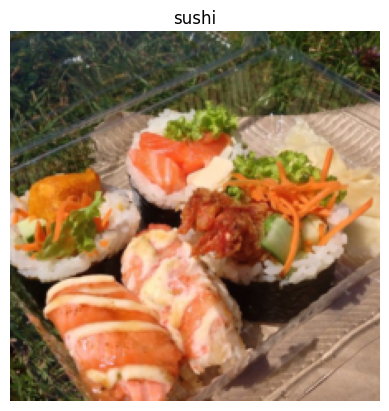

In [62]:
# 1. View single image
view_image(trainset , image , label)
print("Original image shape : " , image.shape)

# 2. Turn image into feature maps
img_out_conv = conv2d(image.unsqueeze(0))
print("image feature map shape" , img_out_conv.shape)

# 3. Flatten the feature maps
img_out_conv_flattened = flatten(img_out_conv)
print("Flattened image feature map shape" , img_out_conv_flattened.shape)

In [63]:
# Get flattened image patch embeddings in right shape
img_out_conv_flattened_reshaped = img_out_conv_flattened.permute(0, 2, 1)
print(f"Patch embedding sequence shape: {img_out_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


We visualize one of the flattened feature map

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

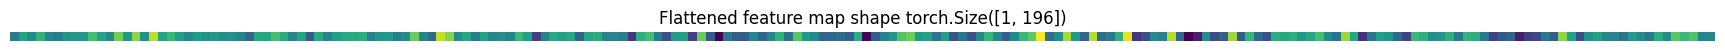

In [64]:
# Get a single flattened feature map
single_flattened_feature_map = img_out_conv_flattened_reshaped[:, :, 0]

# Plot the flattened feature map
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape {single_flattened_feature_map.shape}")
plt.axis(False)



> The original Transformer architecture was designed to work with text. The Vision Transformer architecture (ViT) had the goal of using the original Transformer for images. This is why we're taking a 2D image and formatting it so it appears as a 1D sequence of text.



# Turning the ViT patch embedding layer into a PyTorch module

In [65]:
class PatchEmbedding(nn.Module): # Turns a 2D input image into a 1D sequence learnable embedding vector.

  def __init__(self,
               in_channels = 3,
               patch_size = 16,
               embedding_dim = 768):
    super().__init__()

    self.patcher = nn.Conv2d(in_channels= in_channels,
                             out_channels = embedding_dim,
                             kernel_size = patch_size,
                             stride = patch_size,
                             padding = 0)

    self.flatten = nn.Flatten(start_dim= 2 , end_dim= 3)

  # The forward method
  def forward(self , x):
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    return x_flattened.permute(0, 2, 1)



In [66]:
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")


Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


# Create the class token embedding

In [40]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.0762,  0.0506, -0.1437,  ..., -0.0213, -0.0190, -0.0747],
         [ 0.0070,  0.0203, -0.0676,  ...,  0.0179, -0.0088, -0.0049],
         [ 0.0086,  0.0166, -0.0590,  ...,  0.0236, -0.0072,  0.0025],
         ...,
         [ 0.4061,  0.1087, -0.4836,  ..., -0.2141, -0.0119, -0.1382],
         [ 0.2300, -0.0072, -0.4237,  ..., -0.1124, -0.0464,  0.0213],
         [ 0.1601, -0.0628, -0.3576,  ..., -0.0971, -0.0466,  0.0593]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [68]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size , 1 , embedding_dimension),
                           requires_grad= True)

print(class_token[:, :, :10])
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")



tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]
